# ----------------------------------------------------------------------
# Mutex Runs
# ----------------------------------------------------------------------


Mutex is a software package for finding mutual exclusivity and co-occurrence in cancer genes.

__To disregard the FDR and filtering method__, set:
1. leastPatientThreshold to 100
2. test_gene_threshold to 0
3. mpairPercntile to 100
4. cpairPercentile to 100

# Set parameters

In [ ]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-seg-gl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# only load patients listed in this file. Set to None to use all the patients.

geneFile = None
# Only load genes listed in this file. Set to None to use all the patients


output_prefix =  "output/BRCA_wustl-seg-gl-" # Prefix for "OUTPUT FILES", below:



#OUTPUT FILES-------
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"

# If you want to test all pairs without first using the least mutated patients, run the following cell.

In [1]:
minFreq = 0
leastPatientThreshold = 100
test_gene_threshold = 0
closer_than_distance = 100000000
only_filter_copy_distance = True
cpvaluethreshold = 0.05
mpvaluethreshold = 0.05

# Otherwise, set the parameters in the following cell and run it.

In [1]:
minFreq = 0
# Only load genes mutated at least this many times.


leastPatientThreshold = 15
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 10
# Test genes that are mutated in at least this percentage of the least mutated patients.



closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp. Set to None to prevent any filtering.


only_filter_copy_distance = True
# only filter the distance between copy number segements if True. Default is False.

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.

# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

3842 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


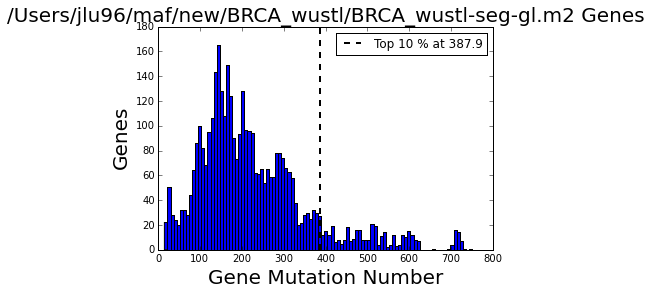

Zoomed into bottom 95 percent region


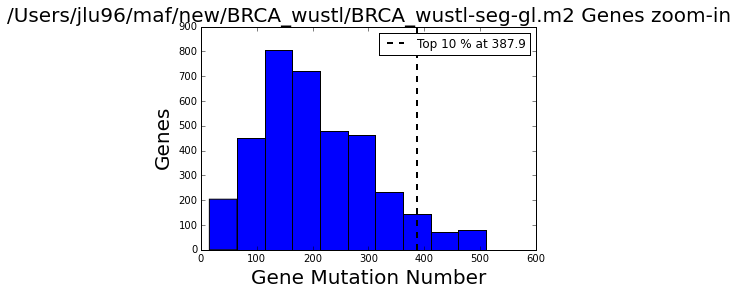


PATIENT MUTATION DISTRIBUTION


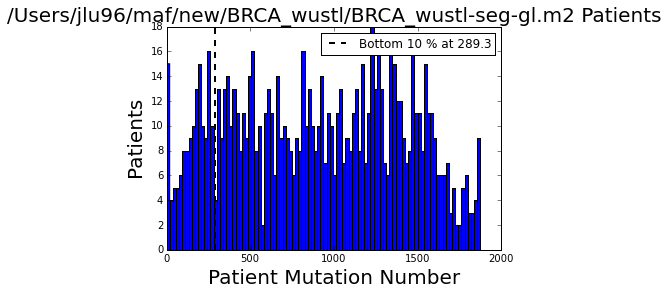

Zoomed into bottom 95 percent region


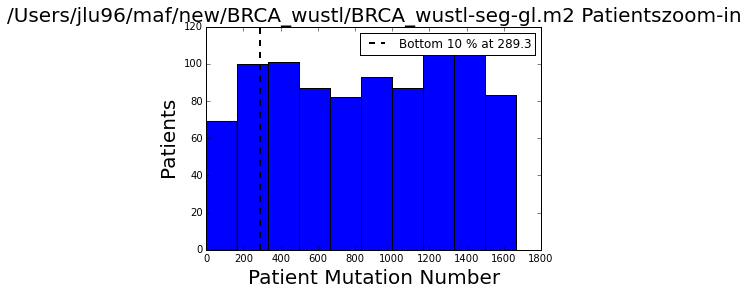

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


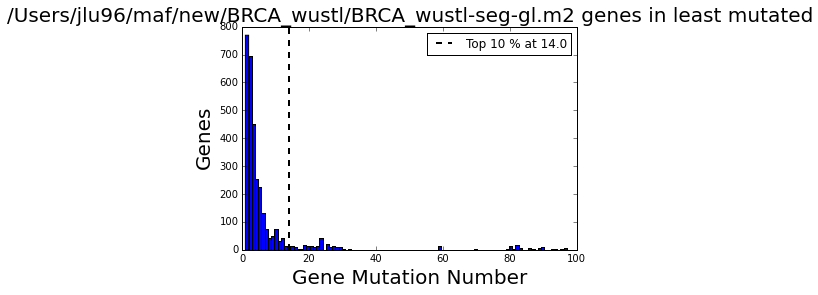


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


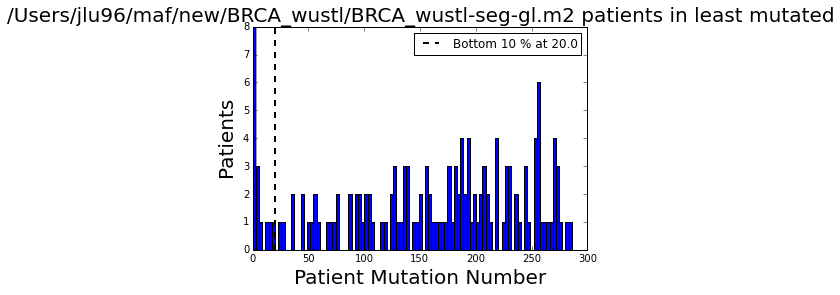

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  15  % of patients
Least mutated patients: 3178 genes x 145 patients
The test gene threshold is  10 % of the least mutated patients
Test genes are mutated at least  14  in th least mutated patients
Number of test genes:  324
Number of pairs to test:  38140
Number of pairs is  38140  retrieved in time :  21.9212839603


0

In [3]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [4]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  73.3440937996
Testing among least mutated patients...
Finished in  48.0278480053
All pairs tested in least mutated patients written to  output/BRCA_wustl-seg-gl-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


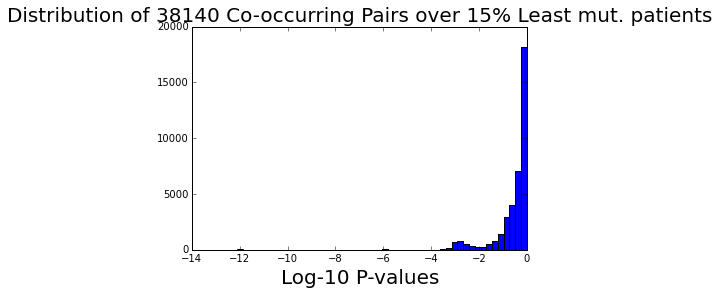

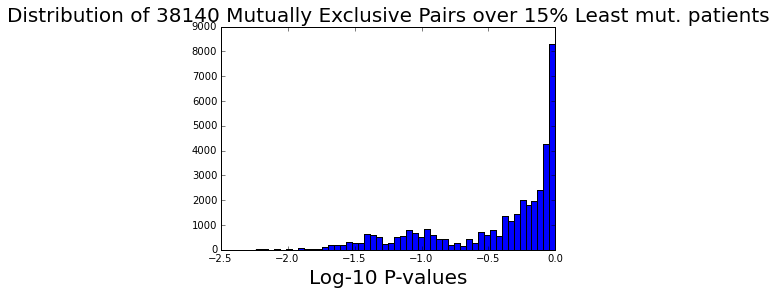

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [6]:
cpairPercentile = 0.5
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 1

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  0.5 percent of cooccurring pairs:  0.000313083037239
Top  1 percent of mutually exclusive pairs :  0.0182279157519
Now number of mutex pairs to test  399
Now number of coocurr pairs to test  191
Number of genes  132


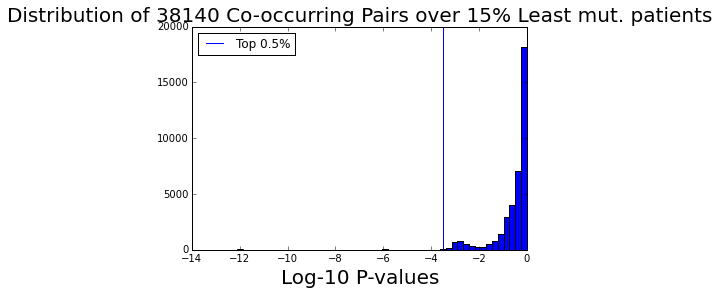

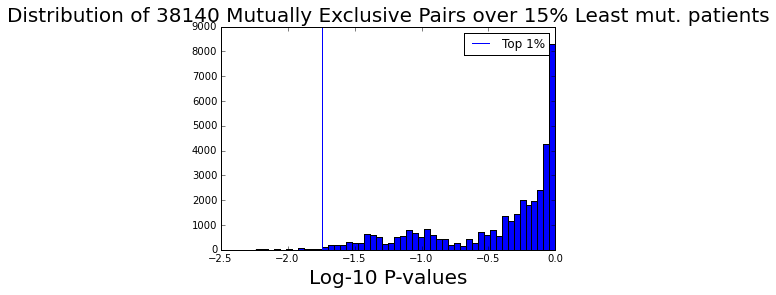

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [8]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/BRCA_wustl-seg-gl--pairs-min_cohort_filtered.txt


0

### Plot results

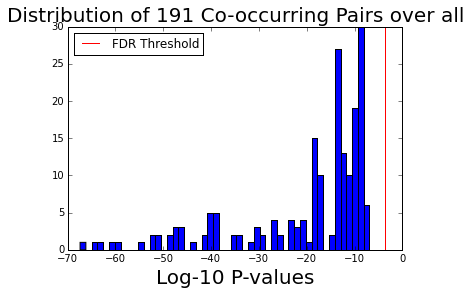

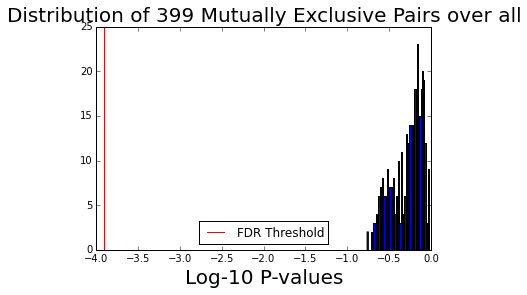

Number significant mutex 0
Number significant coocurr 191


In [9]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
logmp = np.log10(mpvalues)

cthreshold = cpvaluethreshold/len(logcp)
mthreshold = mpvaluethreshold/len(logmp)

if len(logcp) > 1:
    plt.figure()
    plt.hist(logcp, bins=50)
    plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logcp) == 1:
    print "One co-occurring pair with p=", cpvalues[0]

if len(logmp) > 1:
    plt.figure()
    plt.hist(logmp, bins=50)
    plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logmp) == 1:
    print "One mutually exclusive pair with p=", mpvalues[0]


# filter all the pairs




        
# Split into mutex and cooccur
new_sig_m_dict = new_mpairsdict.copy()
new_sig_c_dict = new_cpairsdict.copy()

for pair in new_mpairsdict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_cpairsdict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)
# new_sig_dict = new_pairsdict.copy()
# for pair in new_pairsdict:
#     if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
#         new_sig_dict.pop(pair)

## Mutual exclusivity info

In [10]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

0  Mutually exclusive pairs
updated with segment info  output/BRCA_wustl-seg-gl--mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-seg-gl--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********

**********SINGLE CYTOBANDS**********

**********PAIRED CYTOBANDS**********


0

# Draw mutual exclusivity network

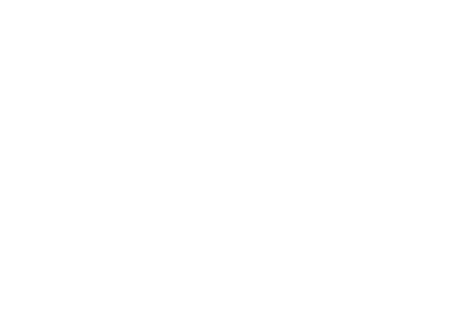

In [40]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [11]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

191  Co-occurring pairs
updated with segment info  output/BRCA_wustl-seg-gl--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-seg-gl--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
SNORA44gain has 45
ARC_JRK_PSCA_LYgain has	26
RN7SL605Ploss has 20
FAM230Closs has 19
SEC22B_PPIAL4A_gain has	17
NOTCH2gain has 17
C8orf17_CHRAC1_gain has	15
TRAPPC9gain has 13
KCNK9gain has 12
RNA5SP264gain has 5
KCNU1gain has 5
UNC5Dgain has 5
ZNF703_ERLIN2_Pgain has	5
BRF2_RAB11FIP1_gain has	5
FAM135B_COL22A1gain has 5
ADAM5_ADAM3Again has 4
DDHD2_PPAPDC1B_gain has	4
TACC1gain has 4
LETM2_FGFR1_RPSgain has	4
PLEKHA2_HTRA4_Tgain has	4
ADAM32gain has 4
ASH2L_STAR_LSM1gain has	4
CEP170_SDCCAG8_gain has	3
ZNF670_ZNF695_Zgain has	3
MTR_MT1HL1gain has 3
RYR2_RN7SKP195_gain has	3
DNAH14_LBR_ENAHgain has	3
CHRM3gain has 3
RGS7_MIR3123_FHgain has	3
ADAM18gain has 3
HHIPL2_TAF1A_MIgain has	3
SMYD3_TFB2M_CNSgain has	3
TMEM78_RAB4A_SPga

0

# Draw co-occurrence network

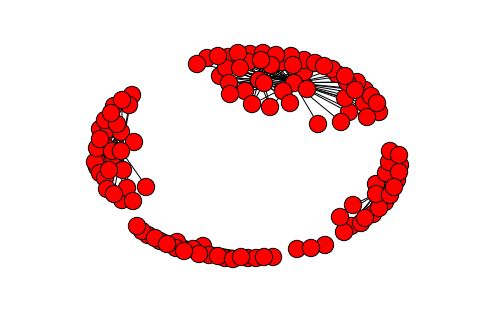


***********************
COMPONENT 0
***********************
Number of nodes  48
Number of edges  79
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
SNORA44gain : 0.96 45
NOTCH2gain : 0.36 17
SEC22B_PPIAL4A_LINC00623_FCGR1B_HIST2H2BA_FAM72Bgain : 0.36 17
---
Writing nodes to:  output/BRCA_wustl-seg-gl--cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  20
Number of edges  19
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
FAM230Closs : 1.0 19
ISXloss : 0.05 1
MN1_PITPNBloss : 0.05 1
---
Writing nodes to:  output/BRCA_wustl-seg-gl--cpairs-min_cohort_filtered_network_comp1.txt

***********************
COMPONENT 2
***********************
Number of nodes  31
Number of edges  71
---
Top 3 nodes by degree centraliy in component 2
Gene: Degree Centrality   Degree
ARC_JRK_PSCA_LY6K_THEM6_SLURP1_LYPD2_LYNX1_LY6D_GML_CYP11B1_CYP11B2_LY6E_C8orf31_LY6H_GPI

In [39]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [12]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********TRIPLET CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  191
Pair info of triplets initialized
0  triplets calculated in  0.00301599502563
Including sorting time  0.00330281257629
